In [92]:

# -*- coding: utf-8 -*-

# -- Sheet --

import pandas as pd 
import re
import os
import string
import csv
import sys
import datetime
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict

In [75]:
tweet_data = pd.read_csv("sentimenttweets.csv")
'''
# tweet_data = pd.concat([pd.read_excel(os.path.join("twitterdata", f), index_col = 0) for f in os.listdir("twitterdata")])

tweet_data = pd.read_csv("searchTweets.csv")

tweet_data = tweet_data[["ticker", "created", "sent_score"]]

tweet_data2 = tweet_data2[["ticker", "created", "sent_score"]]

tweet_data = pd.concat([tweet_data, tweet_data2], axis = 0)

tweet_data.shape

'''
print(tweet_data.head())


returns_data = pd.read_csv("stocks.csv")

returns_data.head()

# returns_data.reset_index(inplace = True)

# returns_data["Date"] = pd.to_datetime(returns_data["Date"]).dt.strftime("%m-%d-%Y")

# returns_data.rename(columns = {"level_0": "ticker", "Date": "date"}, inplace = True)

# returns_data.set_index(["ticker", "date"], inplace = True, drop = True)

# returns_data = returns_data[["Volume", "Adj Close"]]

# returns = returns_data["Adj Close"].groupby(level = 0).apply(lambda x: x / x[1:4].max())
# vol = returns_data.groupby(level = 0)["Volume"].apply(lambda x: x / x[1:4].max())

# returns_data = pd.concat([returns, vol], axis = 1)
# returns_data.rename(columns = {"Adj Close": "return", "Volume": "vol"}, inplace = True)
# returns_data.dropna(inplace = True)

# tweet_data.rename(columns = {"created": "date"}, inplace = True)
# tweet_data.set_index(["ticker", "date"], inplace = True, drop = True)

# # Drop any tweets with 0 sentiment (irrelevant/couldn't be parsed/etc.)

# tweet_data = tweet_data[tweet_data["sent_score"] != 0]

# # Calculate average sentiment score by date

# tweet_sent_data = tweet_data.groupby(["ticker", "date"])["sent_score"].agg(['mean', 'count'])
# tweet_sent_data.columns = ["sent_score", "tweet_volume"]
# tweet_sent_data["tweet_volume"] = tweet_sent_data.groupby(level = 0)["tweet_volume"].apply(lambda x: x / x[1:4].max())

# combined_data = returns_data.merge(tweet_sent_data, left_index = True, right_index = True, how = "left")

# # In case of companies that didn't have any Twitter data for a particular date... 
# combined_data.fillna(0, inplace = True)

# dt = combined_data.reset_index()

# dt["date"] = pd.to_datetime(dt["date"])
# dt.set_index(["ticker", "date"], inplace = True, drop = True)
# dt.sort_index(level = 1, ascending = False, inplace = True)

# target = dt[dt.index.get_level_values(1) == '11-27-2020']
# features = dt[dt.index.get_level_values(1) != '11-27-2020']

# target = target["return"]

  ticker                         created            id  polarity sentiment  \
0    MMM  Thu Mar 31 22:51:05 +0000 2022  1.510000e+18  1.000000  positive   
1    MMM  Thu Mar 31 22:30:02 +0000 2022  1.510000e+18  0.275000  positive   
2    MMM  Thu Mar 31 20:28:37 +0000 2022  1.510000e+18  0.106667  positive   
3    MMM  Thu Mar 31 17:33:06 +0000 2022  1.510000e+18  1.000000  positive   
4    MMM  Tue Mar 29 23:03:05 +0000 2022  1.510000e+18  1.000000  positive   

   subjectivity  
0      0.300000  
1      0.500000  
2      0.526667  
3      0.300000  
4      0.300000  


,ticker,change
0,MMM,0.012653
1,AOS,-0.013987
2,ABT,-0.023078
3,ABBV,0.007997
4,ABMD,0.039578


In [76]:
tweet_agg = tweet_data.groupby(['ticker'],as_index=False).mean()
pd_data = tweet_agg.merge(returns_data)
pd_data

,ticker,id,polarity,subjectivity,change
0,A,1.510000e+18,0.161909,0.329144,-0.017591
1,AAL,1.510000e+18,0.055000,0.140000,0.057178
2,AAPL,1.510000e+18,0.155000,0.250000,0.056476
3,ABBV,1.510000e+18,0.500000,0.150000,0.007997
4,ABC,1.510000e+18,0.000000,0.000000,0.009858
...,...,...,...,...,...
345,WHR,1.510000e+18,0.000000,0.000000,-0.029015
346,WM,1.510000e+18,0.112500,0.300000,0.001602
347,WMT,1.510000e+18,0.493827,0.362963,-0.005408
348,WRK,1.510000e+18,0.191667,0.225000,0.022383


In [96]:
def get_sent(row):
    if row[2] > 0:
        val = 'positive'
    elif row[2] < 0:
        val = 'negative'
    else:
        val = 'neutral'
    return val

In [101]:
pd_data['sentiment'] = pd_data.apply(get_sent, axis=1)
pd_data.groupby(['sentiment']).mean()

,id,polarity,subjectivity,change
sentiment,,,,
negative,1.510000e+18,-0.100785,0.230681,0.021178
neutral,1.510000e+18,0.000000,0.036416,0.011970
positive,1.510000e+18,0.280435,0.332130,0.012844


In [79]:
target = pd_data['change']
features = pd_data[['polarity','subjectivity']]

In [80]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 0, test_size = 0.2)

In [85]:
model = LinearRegression()
model = model.fit(X_train, y_train)

prediction = model.predict(X_test)

mse = mean_squared_error(y_test, prediction)
r2 = r2_score(y_test, prediction)

print("\nThe model performance for training set")
print("--------------------------------------")
print('MSE is {}'.format(mse))
print('R2 is {}'.format(r2))

print("\n")


The model performance for training set
--------------------------------------
MSE is 0.0006894771367669687
R2 is 0.004970468677303441




In [87]:
# KNN Regression
knn = KNeighborsRegressor()
neighbors = list(range(1,51))

param_grid = dict(n_neighbors = neighbors)
knn_grid = GridSearchCV(knn, param_grid, cv=10)

knn_grid.fit(features, target)
y_pred = list(knn_grid.predict(features))
knn_grid.score(features, target) 
knn_grid.best_params_

{'n_neighbors': 50}

Text(0, 0.5, 'Mean Squared Error')

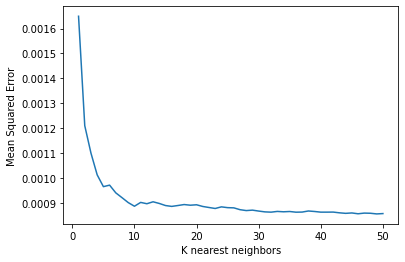

In [93]:
# Graphing the MSE for each hyperparameter
error = []
for k in range(1,51):
    knn = KNeighborsRegressor(n_neighbors=k)
    y_pred = cross_val_predict(knn, features, target, cv=5)
    error.append(mean_squared_error(target,y_pred))
plt.plot(range(1,51),error)
plt.xlabel('K nearest neighbors')
plt.ylabel('Mean Squared Error')

In [ ]:


import random

random.seed(0)

train_tickers = list(random.sample(list(dt.index.get_level_values(0).unique()), 400))
test_tickers = [x for x in dt.index.get_level_values(0).unique() if x not in train_tickers]

import numpy as np 

X_train = np.array([features[features.index.get_level_values(0) == ticker].values.tolist() for ticker in train_tickers])
y_train = np.array([target[target.index.get_level_values(0) == ticker].values.tolist() for ticker in train_tickers])

X_test = np.array([features[features.index.get_level_values(0) == ticker].values.tolist() for ticker in test_tickers])
y_test = np.array([target[target.index.get_level_values(0) == ticker].values.tolist() for ticker in test_tickers])

X_test[1]




In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units = 5))
model.add(Dense(units = 1))

early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)

model.compile(optimizer = "adam", loss = "mean_squared_error")

model.fit(X_train, y_train, epochs = 50, batch_size = 30, callbacks=[early_stop])

model.summary()

y_test_pred = model.predict(X_test)

y_test_pred


In [ ]:


import matplotlib.pyplot as plt

plt.scatter(y_test, y_test_pred)
plt.show()

from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(y_test, y_test_pred))

preds = pd.DataFrame({"Predicted": y_test_pred.flatten(), "Actual": y_test.flatten()})
preds.plot()

results = pd.DataFrame({"Predicted": y_test_pred.flatten(), "Actual": y_test.flatten()}, index = test_tickers)

results.head()

t_0 = features[features.index.get_level_values(1) == '11/25/2020'][["return", "sent_score"]].reset_index(level = 1)

res = results.merge(t_0, how = "left", left_index = True, right_index = True)

res.rename(columns = {"return": "t-1"}, inplace = True)
res.drop(columns = ["date"], inplace = True)

res.head()

ups = res[res["Predicted"] > res["t-1"]]

downs = res[res["Predicted"] < res["t-1"]]

In [ ]:

print("Ups: {} Downs: {}".format(ups.shape[0], downs.shape[0]))

print("Out of {} predicted ups, {} actually went up".format(ups.shape[0], res[(res["Predicted"] > res["t-1"]) & (res["Actual"] > res["t-1"])].shape[0]))

print("Out of {} predicted downs, {} actually went down".format(downs.shape[0], res[(res["Predicted"] < res["t-1"]) & (res["Actual"] < res["t-1"])].shape[0]))

abs_up_ret = (ups["Actual"] - ups["t-1"]).sum()
print("If we bought equally-weighted shares of each predicted up, we would have made: {:.2f}".format(abs_up_ret))
print("Of a total investment of {:.2f}, that's a 1-day return of {:.2f}%".format(ups["t-1"].sum(), abs_up_ret / ups["t-1"].sum() * 100))
print("Annualized, that figure is {:.2f}%".format((np.power(1 + abs_up_ret / ups["t-1"].sum(), 251) - 1) * 100))

abs_down_ret = (downs["t-1"] - downs["Actual"]).sum()
print("If we shorted equally-weighted shares of each predicted down, we would have made: {:.2f}".format(abs_down_ret))
print("Of a total investment of {:.2f} (@150% margin), that's a 1-day return of {:.2f}%".format(downs["t-1"].sum() * 1.5, abs_down_ret / (downs["t-1"].sum() * 1.5) * 100))
print("Annualized, that figure is {:.2f}%".format((np.power(1 + abs_down_ret / (downs["t-1"].sum() * 1.5), 251) - 1) * 100))

# Impact of sentiment on performance

top_sent = res.nlargest(20, columns = "sent_score")
low_sent = res.nsmallest(20, columns = "sent_score")

print("Of 20 companies with highest sentiment at t-1, {} went up, {} went down".format(top_sent[top_sent["Actual"] > top_sent["t-1"]].shape[0], top_sent[top_sent["Actual"] < top_sent["t-1"]].shape[0]))

print("Equal-weighted price return (long highest sentiment companies): {:.2f}".format((top_sent["Actual"] - top_sent["t-1"]).sum()))

print("Of 20 companies with lowest sentiment at t-1, {} went up, {} went down".format(low_sent[low_sent["Actual"] > low_sent["t-1"]].shape[0], low_sent[low_sent["Actual"] < low_sent["t-1"]].shape[0]))

print("Equal-weighted price return (short lowest sentiment companies): {:.2f}".format((low_sent["t-1"] - low_sent["Actual"]).sum()))

tr = (top_sent["Actual"] - top_sent["t-1"]).sum() + (low_sent["t-1"] - low_sent["Actual"]).sum()
print("Strategy: Long Top 20 Sentiment, Short Worst 20 Sentiment")
print("Net price return: {:.2f}".format(tr))
print("Net 1-day : {:.2f}%\nAnnualized: {:.2f}%".format(100 * tr / (top_sent["t-1"].sum() + 1.5 * low_sent["t-1"].sum()), (np.power(1 + tr / (top_sent["t-1"].sum() + 1.5 * low_sent["t-1"].sum()), 251) - 1) * 100))
